# Italian Restaurants in New York City
#### Rameez Riaz

## Introduction

This project searches for the best locations to open Italian restaurants in New York. US Census Bureau states that New York has a population of around 8.4 million (US Census Bureau, 2019). Apart from being a financial hub of the United States, New York boasts on being a multicultural city. A great share comes from the Italian immigrants who form a major part of the population, 8.2% (2006–2008 American Community Survey). Italian cusine has become so famous in New York that it is quite hard finding a reservation for an Italian restaurant. This report explores which neighborhoods and boroughs of New York City have the most Italian restaurants(also highly rated). 
The question to answer is, "Where should a business entrepreneur looking to open an Italian restaurant, should invest?"


## Data 

The data required is New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

Data related to quality and location of Italian restaurants will be retrieved using Foursquare. 

# Methodology

Similar to Week3 Project of IBM Data Science Capstone, Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe with borough, neighborhoods and coordinated.

FourSquare will be used to locate venues and then Italian restaurants will be fintered. Ratings, tips, and likes by users will be counted and added to the dataframe. Since the free subscription is used, we will have one tip for each restaurant

Data will be ordered based on rankings and then will be visually assessed using Python libraries.


# Problem Statement
What is the best location for Italian restaurant in New York City?

In [1]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [7]:
CLIENT_ID = 'XGT33IBAGXTGL5QZLCVIPKYUGNUPS1O1FO5JRDIET5BWYEOE' # your Foursquare ID
CLIENT_SECRET = '04MOK4VUHA1CHMQDJPY4V50QEF2R2RRMY0KYZLPB25HEKVBN' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XGT33IBAGXTGL5QZLCVIPKYUGNUPS1O1FO5JRDIET5BWYEOE
CLIENT_SECRET:04MOK4VUHA1CHMQDJPY4V50QEF2R2RRMY0KYZLPB25HEKVBN


In [3]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
ny_data.shape

(306, 4)

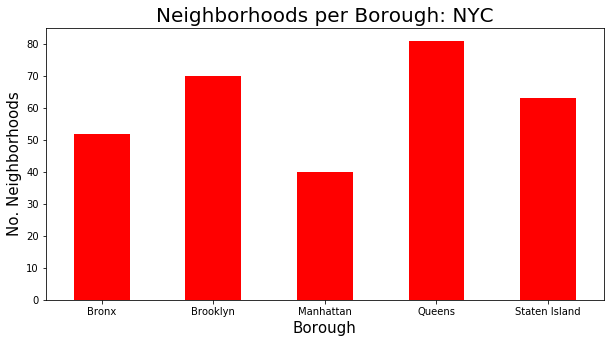

In [13]:
clr = "red"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [8]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 119 / 306 ) Italian Resturants in East Village, Manhattan:3
['Manhattan', 'East Village', 40.727846777270244, -73.98222616506416]
( 120 / 306 ) Italian Resturants in Lower East Side, Manhattan:1
['Manhattan', 'Lower East Side', 40.71780674892765, -73.98089031999291]
( 121 / 306 ) Italian Resturants in Tribeca, Manhattan:1
['Manhattan', 'Tribeca', 40.721521967443216, -74.01068328559087]
( 122 / 306 ) Italian Resturants in Little Italy, Manhattan:3
['Manhattan', 'Little Italy', 40.71932379395907, -73.99730467208073]
( 123 / 306 ) Italian Resturants in Soho, Manhattan:3
['Manhattan', 'Soho', 40.72218384131794, -74.00065666959759]
( 124 / 306 ) Italian Resturants in West Village, Manhattan:10
['Manhattan', 'West Village', 40.73443393572434, -74.00617998126812]
( 125 / 306 ) Italian Resturants in Manhattan Valley, Manhattan:1
['Manhattan', 'Manhattan Valley', 40.797307041702865, -73.96428617740655]
( 126 / 306 ) Italian Resturants in Morningside Heights, Manhattan:0
['Manhattan', 'Morning

( 185 / 306 ) Italian Resturants in Queensboro Hill, Queens:0
['Queens', 'Queensboro Hill', 40.7445723092867, -73.82580915110559]
( 186 / 306 ) Italian Resturants in Hillcrest, Queens:0
['Queens', 'Hillcrest', 40.723824901829204, -73.79760300912672]
( 187 / 306 ) Italian Resturants in Ravenswood, Queens:1
['Queens', 'Ravenswood', 40.761704526054146, -73.93157506072878]
( 188 / 306 ) Italian Resturants in Lindenwood, Queens:0
['Queens', 'Lindenwood', 40.66391841925139, -73.84963782402441]
( 189 / 306 ) Italian Resturants in Laurelton, Queens:0
['Queens', 'Laurelton', 40.66788389660247, -73.74025607989822]
( 190 / 306 ) Italian Resturants in Lefrak City, Queens:0
['Queens', 'Lefrak City', 40.736074570830795, -73.8625247141374]
( 191 / 306 ) Italian Resturants in Belle Harbor, Queens:0
['Queens', 'Belle Harbor', 40.57615556543109, -73.8540175039252]
( 192 / 306 ) Italian Resturants in Rockaway Park, Queens:0
['Queens', 'Rockaway Park', 40.58034295646131, -73.84153370226186]
( 193 / 306 ) 

( 247 / 306 ) Italian Resturants in Bulls Head, Staten Island:0
['Staten Island', 'Bulls Head', 40.6095918004203, -74.15940948657122]
( 248 / 306 ) Italian Resturants in Carnegie Hill, Manhattan:3
['Manhattan', 'Carnegie Hill', 40.7826825671257, -73.95325646837112]
( 249 / 306 ) Italian Resturants in Noho, Manhattan:6
['Manhattan', 'Noho', 40.72325901885768, -73.98843368023597]
( 250 / 306 ) Italian Resturants in Civic Center, Manhattan:2
['Manhattan', 'Civic Center', 40.71522892046282, -74.00541529873355]
( 251 / 306 ) Italian Resturants in Midtown South, Manhattan:1
['Manhattan', 'Midtown South', 40.7485096643122, -73.98871313285247]
( 252 / 306 ) Italian Resturants in Richmond Town, Staten Island:0
['Staten Island', 'Richmond Town', 40.56960594275505, -74.1340572986257]
( 253 / 306 ) Italian Resturants in Shore Acres, Staten Island:2
['Staten Island', 'Shore Acres', 40.60971934079284, -74.06667766061771]
( 254 / 306 ) Italian Resturants in Clifton, Staten Island:0
['Staten Island', 

In [9]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [12]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
1,1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
2,2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta
3,3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood
4,4,Bronx,Bedford Park,4b1712a8f964a520dbc123e3,Jolly Tinker


In [14]:
italian_rest_ny.shape

(224, 5)

Visualize Number of Restaurants per burough

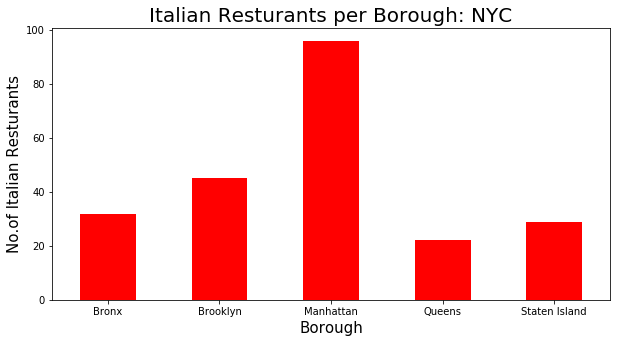

In [15]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

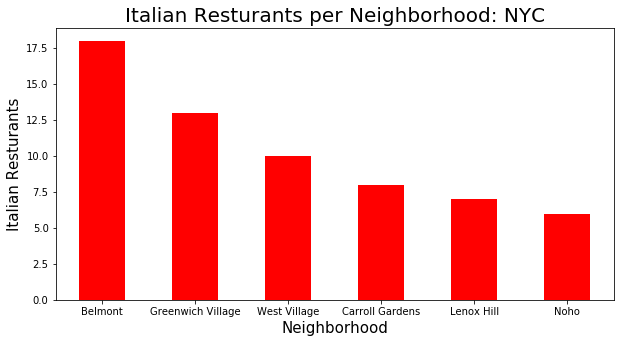

In [16]:
##cheking the same with respect to neighborhoods though
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [17]:
##going deep to study Belmont

italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Unnamed: 0,Borough,Neighborhood,ID,Name
7,7,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
8,8,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
9,9,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
10,10,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
11,11,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
12,12,Bronx,Belmont,4c9b9e7b9c663704b90463fd,Gerbasi Ristorante
13,13,Bronx,Belmont,4bc22a22920eb713bcc51b2c,Tra Di Noi
14,14,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
15,15,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
16,16,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering


In [ ]:
##going deep to study Belmont

italian_rest_ny[italian_rest_ny['Neighborhood']=='Noho']

In [35]:
italian_rest_ny.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [25]:
italian_rest_ny.head().values.tolist()  #just to test if function is working 

[[0,
  'Bronx',
  'Woodlawn',
  '511edb6de4b0d58346fd272d',
  "Patrizia's Of Woodlawn"],
 [1, 'Bronx', 'Pelham Parkway', '4bf96ae65317a593d837017f', "Enzo's"],
 [2, 'Bronx', 'Pelham Parkway', '4b47f069f964a5208c4426e3', 'Pasta Pasta'],
 [3,
  'Bronx',
  'City Island',
  '4514ed4df964a520e5391fe3',
  "Artie's Steak and Seafood"],
 [4, 'Bronx', 'Bedford Park', '4b1712a8f964a520dbc123e3', 'Jolly Tinker']]

In [36]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for rows in italian_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name = rows
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f3ac9d711597434c59bbe49'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}, {'label': 'entrance', 'lat': 40.900601, 'lng': -73.867611}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '5f3acc2297f4146e04135591'}, 'response': {'venue': {'id': '4bf96ae65317a593d837017f', 'name': "Enzo's", 'contact': {'phone': '7184093828', 'formattedPhone': '(718) 409-3828'}, 'location': {'address': '1998 Williamsbridge Rd', 'lat': 40.854232311821725, 'lng': -73.85436243306151, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854232311821725, 'lng': -73.85436243306151}, {'label': 'entrance', 'lat': 40.854116, 'lng': -73.854132}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1998 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/enzos/4bf96ae65317a593d837017f', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '5f3acc0e9ed85e68a250aecd'}, 'response': {'venue': {'id': '4b47f069f964a5208c4426e3', 'name': 'Pasta Pasta', 'contact': {'phone': '7188929634', 'formattedPhone': '(718) 892-9634'}, 'location': {'address': '2023 Williamsbridge Rd', 'lat': 40.85478806485715, 'lng': -73.85492881053774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85478806485715, 'lng': -73.85492881053774}, {'label': 'entrance', 'lat': 40.854792, 'lng': -73.855184}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2023 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasta-pasta/4b47f069f964a5208c4426e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '5f3acb05c9c6b914fd363648'}, 'response': {'venue': {'id': '4b1712a8f964a520dbc123e3', 'name': 'Jolly Tinker', 'contact': {'phone': '3477265644', 'formattedPhone': '(347) 726-5644'}, 'location': {'address': '2875 Webster Ave', 'lat': 40.86745127461597, 'lng': -73.88353583600046, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86745127461597, 'lng': -73.88353583600046}, {'label': 'entrance', 'lat': 40.867508, 'lng': -73.883501}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2875 Webster Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jolly-tinker/4b1712a8f964a520dbc123e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d4898

{'meta': {'code': 200, 'requestId': '5f3acb8f99578521ccbb1d97'}, 'response': {'venue': {'id': '4b10591af964a5205f6e23e3', 'name': "Patricia's", 'contact': {'phone': '7184099069', 'formattedPhone': '(718) 409-9069', 'twitter': 'patriciasnyc'}, 'location': {'address': '1082 Morris Park Ave', 'lat': 40.84931298339339, 'lng': -73.85353576737785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84931298339339, 'lng': -73.85353576737785}, {'label': 'entrance', 'lat': 40.849229, 'lng': -73.853395}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1082 Morris Park Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patricias/4b10591af964a5205f6e23e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5f3acbb566f09152f1510376'}, 'response': {'venue': {'id': '59050f51b23dfa5f6649e678', 'name': 'Arthur Avenue Fiasco', 'contact': {'phone': '7186180806', 'formattedPhone': '(718) 618-0806'}, 'location': {'address': '2376 Arthur Ave', 'crossStreet': '187th street', 'lat': 40.854844, 'lng': -73.887908, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854844, 'lng': -73.887908}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2376 Arthur Ave (187th street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/arthur-avenue-fiasco/59050f51b23dfa5f6649e678', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price'

{'meta': {'code': 200, 'requestId': '5f3acb9bf7e86f7793129bce'}, 'response': {'venue': {'id': '4bb6470cef159c7465b275f7', 'name': 'Calabria Pork Store', 'contact': {'phone': '7183675145', 'formattedPhone': '(718) 367-5145'}, 'location': {'address': '2338 Arthur Ave', 'lat': 40.85414529023418, 'lng': -73.88877606219484, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85414529023418, 'lng': -73.88877606219484}, {'label': 'entrance', 'lat': 40.854096, 'lng': -73.888659}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2338 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/calabria-pork-store/4bb6470cef159c7465b275f7', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4

{'meta': {'code': 200, 'requestId': '5f3acc15cf2d854abd011c32'}, 'response': {'venue': {'id': '4c9b9e7b9c663704b90463fd', 'name': 'Gerbasi Ristorante', 'contact': {'phone': '7182205735', 'formattedPhone': '(718) 220-5735'}, 'location': {'address': '2389 Arthur Ave', 'lat': 40.855704054640576, 'lng': -73.88741072750854, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.855289, 'lng': -73.887951}, {'label': 'display', 'lat': 40.855704054640576, 'lng': -73.88741072750854}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2389 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gerbasi-ristorante/4c9b9e7b9c663704b90463fd', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '5f3acc3bb856fa49bb0eefcd'}, 'response': {'venue': {'id': '4aa425bef964a5208e4520e3', 'name': "Dominick's Restaurant", 'contact': {'phone': '7187332807', 'formattedPhone': '(718) 733-2807', 'twitter': 'dominicksrest'}, 'location': {'address': '2335 Arthur Ave', 'lat': 40.85421506482662, 'lng': -73.88876521498301, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85421506482662, 'lng': -73.88876521498301}, {'label': 'entrance', 'lat': 40.854251, 'lng': -73.888834}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2335 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dominicks-restaurant/4aa425bef964a5208e4520e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '5f3acca77ad0a56d24c274a7'}, 'response': {'venue': {'id': '4b5a4c8ff964a52049bb28e3', 'name': "Emilia's Restaurant", 'contact': {'phone': '7183675915', 'formattedPhone': '(718) 367-5915'}, 'location': {'address': '2331 Arthur Ave', 'lat': 40.85412010500031, 'lng': -73.88890998498077, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85412010500031, 'lng': -73.88890998498077}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2331 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emilias-restaurant/4b5a4c8ff964a52049bb28e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 16}, 'url': 'http://emiliasr

{'meta': {'code': 200, 'requestId': '5f3accaed602790ae6dd5183'}, 'response': {'venue': {'id': '4cb0d382ef1b370419643e00', 'name': "David Greco's Arthur Avenue Trattoria", 'contact': {}, 'location': {'lat': 40.854031511759736, 'lng': -73.88887832314941, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854031511759736, 'lng': -73.88887832314941}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/david-grecos-arthur-avenue-trattoria/4cb0d382ef1b370419643e00', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 6, 'groups'

{'meta': {'code': 200, 'requestId': '5f3acca87ad0a56d24c27785'}, 'response': {'venue': {'id': '4b5bc595f964a520431529e3', 'name': "Pasquale Riggaletto's", 'contact': {'phone': '7183656644', 'formattedPhone': '(718) 365-6644'}, 'location': {'address': '2311 Arthur Ave', 'lat': 40.853744601208376, 'lng': -73.88926386660914, 'labeledLatLngs': [{'label': 'display', 'lat': 40.853744601208376, 'lng': -73.88926386660914}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2311 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasquale-riggalettos/4b5bc595f964a520431529e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 18}, 'price': {'tier':

{'meta': {'code': 200, 'requestId': '5f3aca4351e46d257643bbde'}, 'response': {'venue': {'id': '44941e38f964a52081341fe3', 'name': 'Arthur Avenue Cafe', 'contact': {'phone': '7185620129', 'formattedPhone': '(718) 562-0129', 'twitter': 'mikesfamousdeli'}, 'location': {'address': '2329 Arthur Ave', 'crossStreet': 'Crescent Avenue', 'lat': 40.85406831774407, 'lng': -73.8888375888388, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85406831774407, 'lng': -73.8888375888388}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2329 Arthur Ave (Crescent Avenue)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/arthur-avenue-cafe/44941e38f964a52081341fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5f3aca6a17a0975c8c193c88'}, 'response': {'venue': {'id': '57005f75498ed225ade7266d', 'name': 'Tapas Italiano Fusion Restaurant', 'contact': {'phone': '6462362548', 'formattedPhone': '(646) 236-2548'}, 'location': {'address': '2363 Arthur Ave', 'crossStreet': 'East 186th Street', 'lat': 40.854933, 'lng': -73.888473, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854933, 'lng': -73.888473}, {'label': 'entrance', 'lat': 40.854855, 'lng': -73.888317}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2363 Arthur Ave (East 186th Street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tapas-italiano-fusion-restaurant/57005f75498ed225ade7266d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian

{'meta': {'code': 200, 'requestId': '5f3acc7d2b6bc220ae53b438'}, 'response': {'venue': {'id': '4c9e1ef2542b224b70a3f09f', 'name': 'Lucca Italian Restaurant', 'contact': {'phone': '7188928282', 'formattedPhone': '(718) 892-8282'}, 'location': {'address': '3019 Westchester Ave', 'crossStreet': 'Hobart Ave', 'lat': 40.847676, 'lng': -73.831834, 'labeledLatLngs': [{'label': 'display', 'lat': 40.847676, 'lng': -73.831834}, {'label': 'entrance', 'lat': 40.84769, 'lng': -73.831699}], 'postalCode': '10461', 'cc': 'US', 'neighborhood': 'Pelham Bay', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3019 Westchester Ave (Hobart Ave)', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucca-italian-restaurant/4c9e1ef2542b224b70a3f09f', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/foo

{'meta': {'code': 200, 'requestId': '5f3acc89c5ebcc30c4e591bf'}, 'response': {'venue': {'id': '4c9518076b35a143d5dc21dc', 'name': "Fratelli's", 'contact': {'phone': '7185472489', 'formattedPhone': '(718) 547-2489'}, 'location': {'address': '2507 Eastchester Rd', 'lat': 40.86301897888721, 'lng': -73.84360740712835, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86301897888721, 'lng': -73.84360740712835}, {'label': 'entrance', 'lat': 40.863085, 'lng': -73.8436}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2507 Eastchester Rd', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fratellis/4c9518076b35a143d5dc21dc', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 's

{'meta': {'code': 200, 'requestId': '5f3accc294af785f9455f732'}, 'response': {'venue': {'id': '4b70d8dff964a52063312de3', 'name': 'Tuscany Grill', 'contact': {'phone': '7189215633', 'formattedPhone': '(718) 921-5633'}, 'location': {'address': '8620 3rd Ave', 'lat': 40.62291326029698, 'lng': -74.03138652017468, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62291326029698, 'lng': -74.03138652017468}, {'label': 'entrance', 'lat': 40.622918, 'lng': -74.031438}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8620 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tuscany-grill/4b70d8dff964a52063312de3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 's

{'meta': {'code': 200, 'requestId': '5f3acc3eb856fa49bb0efd90'}, 'response': {'venue': {'id': '4ad62c95f964a5208d0521e3', 'name': 'Zio Toto', 'contact': {'phone': '7182388042', 'formattedPhone': '(718) 238-8042'}, 'location': {'address': '8407 3rd Ave', 'crossStreet': 'btwn 84th & 85th St', 'lat': 40.62479085034183, 'lng': -74.03055087900958, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62479085034183, 'lng': -74.03055087900958}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8407 3rd Ave (btwn 84th & 85th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zio-toto/4ad62c95f964a5208d0521e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d94173

{'meta': {'code': 200, 'requestId': '5f3acc90c02449411830ccc6'}, 'response': {'venue': {'id': '4a7e205ef964a52012f11fe3', 'name': 'Sofia Restorante Italiano', 'contact': {'phone': '7186804242', 'formattedPhone': '(718) 680-4242'}, 'location': {'address': '8406 3rd Ave', 'crossStreet': 'Betw. 84th & 85th St.', 'lat': 40.62484745920055, 'lng': -74.03052232818622, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62484745920055, 'lng': -74.03052232818622}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8406 3rd Ave (Betw. 84th & 85th St.)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sofia-restorante-italiano/4a7e205ef964a52012f11fe3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '5f3acc1a56e24d6083f91f8a'}, 'response': {'venue': {'id': '5071f049e4b05fb6c443ec8e', 'name': "Zitelli's Thin Crust Pizza and Bar", 'contact': {}, 'location': {'address': '8530-3rd Avenue', 'crossStreet': '86st & 3ave Corner', 'lat': 40.62355539009036, 'lng': -74.03096914529038, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62355539009036, 'lng': -74.03096914529038}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8530-3rd Avenue (86st & 3ave Corner)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zitellis-thin-crust-pizza-and-bar/5071f049e4b05fb6c443ec8e', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca941735'

{'meta': {'code': 200, 'requestId': '5f3accc394af785f9455fc21'}, 'response': {'venue': {'id': '4e30a139483bb3fdc436a7e3', 'name': 'Villa Fiorita', 'contact': {'phone': '7188377950', 'formattedPhone': '(718) 837-7950'}, 'location': {'address': '7720 18th Ave', 'lat': 40.611931, 'lng': -73.997854, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611931, 'lng': -73.997854}, {'label': 'entrance', 'lat': 40.611851, 'lng': -73.997718}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7720 18th Ave', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/villa-fiorita/4e30a139483bb3fdc436a7e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'pric

{'meta': {'code': 200, 'requestId': '5f3aca4651e46d257643c8c8'}, 'response': {'venue': {'id': '5095a98ae4b0038a605e6f45', 'name': 'Cafe Lore', 'contact': {'phone': '7184927100', 'formattedPhone': '(718) 492-7100', 'twitter': 'cafelore1'}, 'location': {'address': '4601 4th Ave', 'crossStreet': '46th Street', 'lat': 40.648474, 'lng': -74.01008900000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.648474, 'lng': -74.01008900000001}, {'label': 'entrance', 'lat': 40.648525, 'lng': -74.010174}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4601 4th Ave (46th Street)', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-lore/5095a98ae4b0038a605e6f45', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '5f3acbb6e558fd1ef5a46ca0'}, 'response': {'venue': {'id': '4ad8c329f964a520731421e3', 'name': "Joe's of Avenue U", 'contact': {'phone': '7184499285', 'formattedPhone': '(718) 449-9285'}, 'location': {'address': '287 Avenue U', 'lat': 40.596970812269824, 'lng': -73.9736772701698, 'labeledLatLngs': [{'label': 'display', 'lat': 40.596970812269824, 'lng': -73.9736772701698}, {'label': 'entrance', 'lat': 40.597039, 'lng': -73.973681}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['287 Avenue U', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-of-avenue-u/4ad8c329f964a520731421e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': F

{'meta': {'code': 200, 'requestId': '5f3accac7ad0a56d24c28906'}, 'response': {'venue': {'id': '5a98aed16a59506d7a60d67c', 'name': 'Carmenta’s', 'contact': {'phone': '7186765003', 'formattedPhone': '(718) 676-5003'}, 'location': {'address': '50 Starr St', 'crossStreet': 'Wilson Ave', 'lat': 40.701320324636875, 'lng': -73.92678265951356, 'labeledLatLngs': [{'label': 'display', 'lat': 40.701320324636875, 'lng': -73.92678265951356}], 'postalCode': '11221', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['50 Starr St (Wilson Ave)', 'Brooklyn, NY 11221', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/carmentas/5a98aed16a59506d7a60d67c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 21},

( 43 / 224 ) processed
{'meta': {'code': 200, 'requestId': '5f3acb9699578521ccbb3e9f'}, 'response': {'venue': {'id': '3fd66200f964a52011f11ee3', 'name': 'Caffe Buon Gusto', 'contact': {'phone': '7186243838', 'formattedPhone': '(718) 624-3838'}, 'location': {'address': '151 Montague St', 'lat': 40.69461587788547, 'lng': -73.99338165894984, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69461587788547, 'lng': -73.99338165894984}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 Montague St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caffe-buon-gusto/3fd66200f964a52011f11ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 19}, 

{'meta': {'code': 200, 'requestId': '5f3acc41b856fa49bb0f08c5'}, 'response': {'venue': {'id': '5a0740a3e1f22816d11723d5', 'name': 'Lillo', 'contact': {'phone': '3477630899', 'formattedPhone': '(347) 763-0899'}, 'location': {'address': '331 Henry Street', 'lat': 40.690199941477445, 'lng': -73.99654010450837, 'labeledLatLngs': [{'label': 'display', 'lat': 40.690199941477445, 'lng': -73.99654010450837}], 'postalCode': '11201', 'cc': 'US', 'neighborhood': 'Cobble Hill', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['331 Henry Street', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lillo/5a0740a3e1f22816d11723d5', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop'

{'meta': {'code': 200, 'requestId': '5f3acdd4c84c6d0398c5d19e'}, 'response': {'venue': {'id': '593329652632ec0582bd71df', 'name': 'Popina', 'contact': {'phone': '7182221901', 'formattedPhone': '(718) 222-1901', 'instagram': 'popinanyc', 'facebook': '1677291285901282', 'facebookUsername': 'PopinaNYC', 'facebookName': 'Popina NYC'}, 'location': {'address': '127 Columbia St', 'lat': 40.687419734537926, 'lng': -74.00143152860893, 'labeledLatLngs': [{'label': 'display', 'lat': 40.687419734537926, 'lng': -74.00143152860893}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['127 Columbia St', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/popina/593329652632ec0582bd71df', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'su

{'meta': {'code': 200, 'requestId': '5f3ac9e111597434c59be725'}, 'response': {'venue': {'id': '49c4ff90f964a520da561fe3', 'name': 'Fragole', 'contact': {'phone': '7185227133', 'formattedPhone': '(718) 522-7133', 'twitter': 'fragoleny', 'facebook': '223164304439051', 'facebookName': 'Fragole Restaurant'}, 'location': {'address': '394 Court St', 'crossStreet': 'btwn 1st Pl & Carroll St.', 'lat': 40.680805, 'lng': -73.99689, 'labeledLatLngs': [{'label': 'display', 'lat': 40.680805, 'lng': -73.99689}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['394 Court St (btwn 1st Pl & Carroll St.)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/fragoleny', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5f3acc822b6bc220ae53c7ae'}, 'response': {'venue': {'id': '506cb4a8e4b02db545b4bf5c', 'name': "Claudine's", 'contact': {'phone': '7182374992', 'formattedPhone': '(718) 237-4992', 'facebook': '496394810370638', 'facebookName': "Claudine's"}, 'location': {'address': '311 Smith St', 'crossStreet': 'Smith St & Union St', 'lat': 40.681352187513205, 'lng': -73.99410672670723, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681352187513205, 'lng': -73.99410672670723}, {'label': 'entrance', 'lat': 40.681307, 'lng': -73.99402}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['311 Smith St (Smith St & Union St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/claudines/506cb4a8e4b02db545b4bf5c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix':

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f3acbce29b3b45474bd67f3'}, 'response': {}}


KeyError: 'venue'

In [37]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [38]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [39]:
italian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,34.580000,7.500000,16.680000
std,34.622212,1.733582,13.593876
min,0.000000,0.000000,0.000000
25%,10.250000,7.225000,6.000000
50%,22.000000,7.850000,12.500000
75%,44.000000,8.375000,25.750000
max,145.000000,9.400000,48.000000


#Note: Foursquare has available data of only 50 restaurants that are Italian out of round about 200. So we decide on work on this complete information

### Further Analysis

In [40]:
#Best restaurant based on user likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                145
Rating                               9.3
Tips                                  48
Name: 7, dtype: object

In [42]:
# Highest tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                145
Rating                               9.3
Tips                                  48
Name: 7, dtype: object

In [41]:
# best rating
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                          Carmenta’s
Likes                                 58
Rating                               9.4
Tips                                  21
Name: 41, dtype: object

In [43]:
#Grouping on borough and finding maximum rating

ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,7.721053
0,Bronx,7.364516


In [44]:
#Neighborhood vs rating
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
6,Bushwick,9.400000
15,Morris Park,8.500000
9,Cobble Hill,8.466667
18,Pelham Gardens,8.400000
8,City Island,8.400000
21,Woodlawn,8.400000
2,Bedford Stuyvesant,8.400000
14,Greenpoint,8.000000
7,Carroll Gardens,7.966667
13,Gravesend,7.700000


In [45]:
#average ratings
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Bedford Stuyvesant,8.400000
6,Bushwick,9.400000
8,City Island,8.400000
9,Cobble Hill,8.466667
14,Greenpoint,8.000000
15,Morris Park,8.500000
18,Pelham Gardens,8.400000
21,Woodlawn,8.400000


In [46]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.400000
1,Brooklyn,Bushwick,40.698116,-73.925258,9.400000
2,Bronx,City Island,40.847247,-73.786488,8.400000
3,Brooklyn,Cobble Hill,40.687920,-73.998561,8.466667
4,Brooklyn,Greenpoint,40.730201,-73.954241,8.000000
5,Bronx,Morris Park,40.847549,-73.850402,8.500000
6,Bronx,Pelham Gardens,40.862966,-73.841612,8.400000
7,Bronx,Woodlawn,40.898273,-73.867315,8.400000


In [48]:
# Folium map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# feature group initialization
incidents = folium.map.FeatureGroup()
# loop and add
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [49]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Conclusion

Brooklyn and Bronx have the best rated Italian restaurants overall. Belmont of The Bronx is the neighborhood in all of NYC with the most Italian Restaurants. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Italian restaurants. Based on this information, Woodland and Pehlam Gardens are the best locations for Italian cuisine in NYC if our criteria is looking at least average ratings. The ratings are less and so the competition would be lower. 
At the end, multiple data sources such as median income, rental values, population, race should be taken into account to further build on this analysis. 